In [1]:
# Libraries
import keras
import tensorflow
from skimage import io
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Flatten

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input



#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import decode_predictions
#from keras.applications.vgg16 import VGG16
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split

%matplotlib inline


In [2]:
DATASET_PATH = 'dataset/food'

# glob through the directory (returns a list of all file paths)
food_path = os.path.join(DATASET_PATH,  '*')
food_path = glob.glob(food_path)

In [3]:
# pre-process images
# Saves the dictionary of the images: each name corresponds to an image

dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)


images_dic = {}
for i,path in enumerate(food_path):
    name = path.split("/")[2].split(".")[0]
    image = load_img(food_path[i], target_size=(240, 350))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image) # for VGG model
    images_dic[name] = image

        #print(name)
    
# save 
with open('imagesdic_effnet.pickle', 'wb') as handle:
    pickle.dump(images_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 19/05/2021 11:26:22
date and time = 19/05/2021 11:29:20


In [3]:
# load already processed images
with open("imagesdic_effnet.pickle", "rb") as fp:   # Unpickling
    images_dic = pickle.load(fp)

In [5]:
# load model
# change input tensor
# add flattening layer
#model = EfficientNetB0(include_top=False,input_tensor=Input(shape=(240, 350, 3)))
model = EfficientNetB0(input_tensor=Input(shape=(240, 350, 3)))


#max1 = MaxPool2D(pool_size=(2, 2))(model.layers[-2].output)
#flat1 = Flatten()(model.layers[-2].output)
model = Model(inputs=model.inputs, outputs=model.outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 350, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 350, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 350, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 351, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [6]:
# open the training triplets
# Create the training sample shuffling B and C and saving labels 0 if ACB and label 1 if ABC

with open('dataset/train_triplets.txt') as f:
    triplets_original = f.readlines()
triplets_original = [line.strip("\n").split(" ") for line in triplets_original]
#triplets_original
triplets = []
labels = []
for i,names in enumerate(triplets_original):
    tmp = {}
    tmp['B'] = names[1]
    tmp['C'] = names[2]
    #print(copy)
    l = list(tmp.items())
    random.shuffle(l)
    d = dict(l)
    #print(l)
    triplets.append([names[0],l[0][1],l[1][1]])
    #print(new_lines)
    if d['B'] == l[0][1]:
        labels.append(1.)
    else:
        labels.append(0.)

In [7]:
#save the names of the images in order of appearance! (can be useful)
names_list = []
for triplet in triplets:
    for name in triplet:
        if name not in names_list:
            names_list.append(name)
print("total number of names in the training triplets: ",len(names_list))
print("total number of images: ",len(food_path))

total number of names in the training triplets:  5000
total number of images:  10000


In [8]:
# Preprocess the images with the pretrained CNN 

dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

print("total number of images to preprocess: ",len(names_list))
features = {}
for name in names_list:
    features[name] = model.predict(images_dic[name])
    #print(features.shape)

# save
with open("features_effnet_withoutput_all.pickle", "wb") as fp:   #Pickling
    pickle.dump(features, fp)
    
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 19/05/2021 11:47:19
total number of images to preprocess:  5000
date and time = 19/05/2021 12:01:30


In [8]:
# load already processed features
with open("features_effnet_withoutput_all.pickle", "rb") as fp:   # Unpickling
    features = pickle.load(fp)

In [ ]:
# Preprocessing for the DNN

In [9]:
len(features[triplets[0][0]][0])*3

3000

In [10]:
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

training_dataset = []

for triplet in triplets:
    #print(triplet)
    tmp = np.hstack(( features[triplet[0]][0], features[triplet[1]][0],features[triplet[2]][0]))
    #tmp = features[triplet[0]][0]
    #print(len(features[triplet[0]][0]),len(tmp))
    training_dataset.append(tmp)
    #training_dataset.append([item for name in triplet for item in features[name][0] ])
    
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 19/05/2021 12:01:53
date and time = 19/05/2021 12:01:54


In [11]:
print(len(training_dataset),len(triplets),len(np.array(training_dataset).shape))

59515 59515 2


In [ ]:
# DNN


In [12]:
X_train, X_vt, y_train, y_vt = train_test_split(np.array(training_dataset), np.array(labels), train_size=0.80)
X_validation, X_test, y_validation, y_test = train_test_split(X_vt, y_vt, train_size=0.5)

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.constraints import unit_norm

In [ ]:
# Easy Model 

activation = 'relu'
input  = Input((X_train.shape[1],))
layer  = Dense(300, activation=activation   , name='dense1')(input)
layer = Dropout(0.2, name = 'drop1')(layer)
layer  = Dense(200, activation=activation   , name='dense2')(layer)
layer = Dropout(0.2, name = 'drop2')(layer)

output = Dense(  1, activation='sigmoid', name='output', )(layer)

model = Model(input, output)

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['acc','mae'],
)

history = model.fit(X_train, y_train,validation_data = (X_validation,y_validation), epochs=40, batch_size=64)

Epoch 1/40
744/744 [==============================] - 3s 3ms/step - loss: 0.6574 - acc: 0.5907 - mae: 0.4686 - val_loss: 0.5786 - val_acc: 0.6947 - val_mae: 0.4033
Epoch 2/40
744/744 [==============================] - 2s 3ms/step - loss: 0.5658 - acc: 0.7056 - mae: 0.3872 - val_loss: 0.5538 - val_acc: 0.7118 - val_mae: 0.3739
Epoch 3/40
744/744 [==============================] - 2s 3ms/step - loss: 0.5248 - acc: 0.7366 - mae: 0.3559 - val_loss: 0.5485 - val_acc: 0.7189 - val_mae: 0.3602
Epoch 4/40
744/744 [==============================] - 2s 3ms/step - loss: 0.4882 - acc: 0.7648 - mae: 0.3279 - val_loss: 0.5405 - val_acc: 0.7276 - val_mae: 0.3465
Epoch 5/40
744/744 [==============================] - 2s 3ms/step - loss: 0.4436 - acc: 0.7913 - mae: 0.2962 - val_loss: 0.5328 - val_acc: 0.7412 - val_mae: 0.3320
Epoch 6/40
744/744 [==============================] - 2s 3ms/step - loss: 0.3981 - acc: 0.8167 - mae: 0.2652 - val_loss: 0.5386 - val_acc: 0.7416 - val_mae: 0.3206
Epoch 7/40
744/7

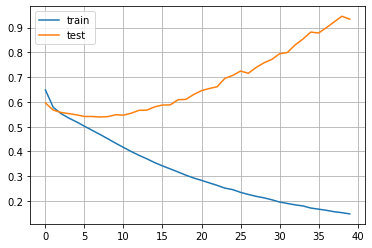

In [15]:
# loss plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plt.yscale('log')
center = min(history.history['val_loss'] + history.history['loss'])
plt.grid(True)

plt.show()